In [16]:

import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2 
import IPython
from glob import glob
from torch.utils.data import Dataset,DataLoader
from sklearn.model_selection import train_test_split
import tqdm
#import seaborn as sns
import albumentations as A
import torch
import torch.nn as nn
import timm
import torcheval 
import wandb
import torchvision
from sklearn.model_selection import StratifiedKFold
from scipy import stats
import seaborn as sns
from albumentations.pytorch import ToTensorV2
plt.style.use('ggplot')
plt.rcParams.update(**{'figure.dpi':150})
import psutil

# select Device

In [17]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATA_DIRECTORY = os.path.join(os.getcwd(),"data")
torch.cuda.empty_cache()

In [18]:
class Config():

    BASE_DIR = os.path.join(os.getcwd() , 'data')
    train_df = pd.read_csv(BASE_DIR  +  '/train.csv')
    TRAIN_VAL_SPLIT_SIZE = 0.2
    TRAIN_BATCH_SIZE = 256
    VAL_BATCH_SIZE = 256

    LR_MAX = 1e-4 
    NUM_EPOCHS = 18
    TIM_NUM_CLASS = 768
    NORMALIZE_TARGET = "log_transform"
    RANDOM_NUMBER = 42
    NUM_FLODS  = 5
    NUM_CLASSES = 6
    TRAITS_NAME = ['X4_mean', 'X11_mean', 'X18_mean', 'X26_mean', 'X50_mean', 'X3112_mean' ]
    FOLD = 0 # Which fold to set as validation data
    IMAGE_SIZE =128
    TARGET_IMAGE_SIZE =  128
    T_MAX =        9
    LR_MODE = "step" # LR scheduler mode from one of "cos", "step", "exp"
    torch.manual_seed(RANDOM_NUMBER)
    INCLUDE_EXTRA_FEATURES = True
    EXTRA_FEATURES_NORMALIZATION = "min_max_normalization"
    WEIGHT_DECAY = 0.01
    TABULAR_NN_OUTPUT  = 256
    TIM_MODEL_NAME = "efficientnet_v2" # "swin_large"
    
    # use XGBBOOST to find prominant features
    EXTRA_COLOUMN = [
    'WORLDCLIM_BIO1_annual_mean_temperature',
'WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month',
'WORLDCLIM_BIO15_precipitation_seasonality',
'WORLDCLIM_BIO4_temperature_seasonality',
'SOIL_ocd_100.200cm_mean_0.01_deg',
'WORLDCLIM_BIO12_annual_precipitation',
'WORLDCLIM_BIO7_temperature_annual_range',
'SOIL_cec_0.5cm_mean_0.01_deg',
'SOIL_nitrogen_0.5cm_mean_0.01_deg',
'SOIL_ocd_60.100cm_mean_0.01_deg',
'SOIL_ocd_30.60cm_mean_0.01_deg',
'SOIL_clay_100.200cm_mean_0.01_deg',
'SOIL_soc_100.200cm_mean_0.01_deg',
'SOIL_nitrogen_100.200cm_mean_0.01_deg',
'SOIL_cec_100.200cm_mean_0.01_deg',
'SOIL_clay_15.30cm_mean_0.01_deg',
'SOIL_soc_60.100cm_mean_0.01_deg',
'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m10',
'SOIL_nitrogen_30.60cm_mean_0.01_deg',
'SOIL_clay_5.15cm_mean_0.01_deg',
'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m4',
'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m11',
'SOIL_ocd_0.5cm_mean_0.01_deg',
'SOIL_ocd_5.15cm_mean_0.01_deg',
'SOIL_cfvo_100.200cm_mean_0.01_deg',
'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m5',
'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m6',
'SOIL_cfvo_30.60cm_mean_0.01_deg',
'SOIL_cfvo_0.5cm_mean_0.01_deg',
'SOIL_soc_15.30cm_mean_0.01_deg',
'SOIL_nitrogen_15.30cm_mean_0.01_deg',
'SOIL_nitrogen_5.15cm_mean_0.01_deg',
'SOIL_clay_0.5cm_mean_0.01_deg',
'SOIL_nitrogen_60.100cm_mean_0.01_deg',
'SOIL_soc_0.5cm_mean_0.01_deg',
'SOIL_ocd_15.30cm_mean_0.01_deg',
'SOIL_ocs_0.30cm_mean_0.01_deg',
'SOIL_clay_30.60cm_mean_0.01_deg',
'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m3',
'SOIL_cfvo_15.30cm_mean_0.01_deg',
'SOIL_silt_100.200cm_mean_0.01_deg',
'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m8',
'SOIL_soc_30.60cm_mean_0.01_deg',
'SOIL_cfvo_5.15cm_mean_0.01_deg',
'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m12',
'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m10',
'SOIL_silt_0.5cm_mean_0.01_deg',
'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m7',
'SOIL_sand_100.200cm_mean_0.01_deg',
'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m3',
'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m12'
]
  
CONFIG = Config()



In [19]:

from sklearn.preprocessing import StandardScaler , MinMaxScaler
SCALAR = None

def create_val_train_dataset(BASE_DIR,train_split_size):
    global SCALAR
    df = pd.read_csv(BASE_DIR  +  '/train.csv')
    if CONFIG.INCLUDE_EXTRA_FEATURES :
        df = df[["id"] +CONFIG.EXTRA_COLOUMN + CONFIG.TRAITS_NAME]
        df["image_path"] = BASE_DIR + "/train_images/" + df["id"].astype(str) + ".jpeg"   # add images in the training datafram
    else :  
        df["image_path"] = BASE_DIR + "/train_images/" + df["id"].astype(str) + ".jpeg"   # add images in the training dataframe
        df = df[["id"] + ["image_path"] ]
    
    # do the normalization
    if CONFIG.INCLUDE_EXTRA_FEATURES:
        if CONFIG.EXTRA_FEATURES_NORMALIZATION == "StandardScaler":
            SCALAR = StandardScaler()
            # standardize the dataset ( tabular dataset )
            SCALAR.fit(df[CONFIG.EXTRA_COLOUMN])
            df[CONFIG.EXTRA_COLOUMN] = SCALAR.transform(df[CONFIG.EXTRA_COLOUMN])
        elif CONFIG.EXTRA_FEATURES_NORMALIZATION == "min_max_normalization":
            SCALAR = MinMaxScaler()
            # standardize the dataset ( tabular dataset )
            SCALAR.fit(df[CONFIG.EXTRA_COLOUMN])
            df[CONFIG.EXTRA_COLOUMN] = SCALAR.transform(df[CONFIG.EXTRA_COLOUMN])
    
    
    
    
    # skf = StratifiedKFold(n_splits=NUM_FLODS, shuffle=True, random_state=42)

    # # Create separate bin for each traits
    # for i, trait in enumerate(TRAITS_NAME):

    #     # Determine the bin edges dynamically based on the distribution of traits
    #     bin_edges = np.percentile(df[trait], np.linspace(0, 100, NUM_FLODS + 1))
    #     df[f"bin_{i}"] = np.digitize(df[trait], bin_edges)

    # # Concatenate the bins into a final bin
    # df["final_bin"] = (
    #     df[[f"bin_{i}" for i in range(NUM_CLASSES)]]
    #     .astype(str)
    #     .agg("".join, axis=1)
    # )

    # # Perform the stratified split using final bin
    # df = df.reset_index(drop=True)
    # for fold, (train_idx, valid_idx) in enumerate(skf.split(df, df["final_bin"])):
    #     df.loc[valid_idx, "fold"] = fold
    # sample_df = df.copy()
    # train_df = sample_df[sample_df.fold != FOLD]
    # val_df = sample_df[sample_df.fold == FOLD]

    
    train_df , val_df = train_test_split(df,test_size=train_split_size,shuffle=True)
    

    print(f"before removing the outliers Num Train: {len(train_df)} | Num Valid: {len(val_df)}")
    # upper_quantiles = train_df[CONFIG.TRAITS_NAME].quantile(0.98)
    # retained_flag = (train_df[CONFIG.TRAITS_NAME] < upper_quantiles).all(axis= 1) & (train_df[CONFIG.TRAITS_NAME] > 0).all(axis=1)
    # train_df = train_df[retained_flag]
    train_df = train_df[(np.abs(stats.zscore(np.log10(train_df[CONFIG.TRAITS_NAME]))<3).all(axis=1)  )]
    train_df.reset_index(drop=True , inplace  = True)
    val_df.reset_index(drop = True , inplace = True)
    print(f"after removing the outliers Num Train: {len(train_df)} | Num Valid: {len(val_df)}")

        
    return  train_df , val_df



def create_test_dataset(BASE_DIR):
    global SCALAR
    df = pd.read_csv(BASE_DIR  +  '/test.csv')
    if CONFIG.INCLUDE_EXTRA_FEATURES:
        #print(df.columns)
        df = df[["id"] +CONFIG.EXTRA_COLOUMN]
        df["image_path"] = BASE_DIR + "/test_images/" + df["id"].astype(str) + ".jpeg"   # add images in the training dataframe
        df[CONFIG.EXTRA_COLOUMN] = SCALAR.transform(df[CONFIG.EXTRA_COLOUMN])   
    else :
        df = df[["id"] +CONFIG.EXTRA_COLOUMN + CONFIG.TRAITS_NAME]
        df["image_path"] = BASE_DIR + "/test_images/" + df["id"].astype(str) + ".jpeg"   # add images in the training dataframe
        df = df[["id"] + ["image_path"] ]
    return df

train_df , val_df = create_val_train_dataset(CONFIG.BASE_DIR,CONFIG.TRAIN_VAL_SPLIT_SIZE)
test_df = create_test_dataset(CONFIG.BASE_DIR)



# some hyper parameter for lr scheduler
CONFIG.N_TRAIN_SAMPLES = len(train_df)
CONFIG.N_STEPS_PER_EPOCH = (CONFIG.N_TRAIN_SAMPLES // CONFIG.TRAIN_BATCH_SIZE)
CONFIG.N_STEPS = CONFIG.N_STEPS_PER_EPOCH * CONFIG.NUM_EPOCHS + 1

before removing the outliers Num Train: 34690 | Num Valid: 8673
after removing the outliers Num Train: 31667 | Num Valid: 8673


/home/prajwal/anaconda3/envs/pytorch_gpu/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/prajwal/anaconda3/envs/pytorch_gpu/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/prajwal/anaconda3/envs/pytorch_gpu/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/prajwal/anaconda3/envs/pytorch_gpu/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprec

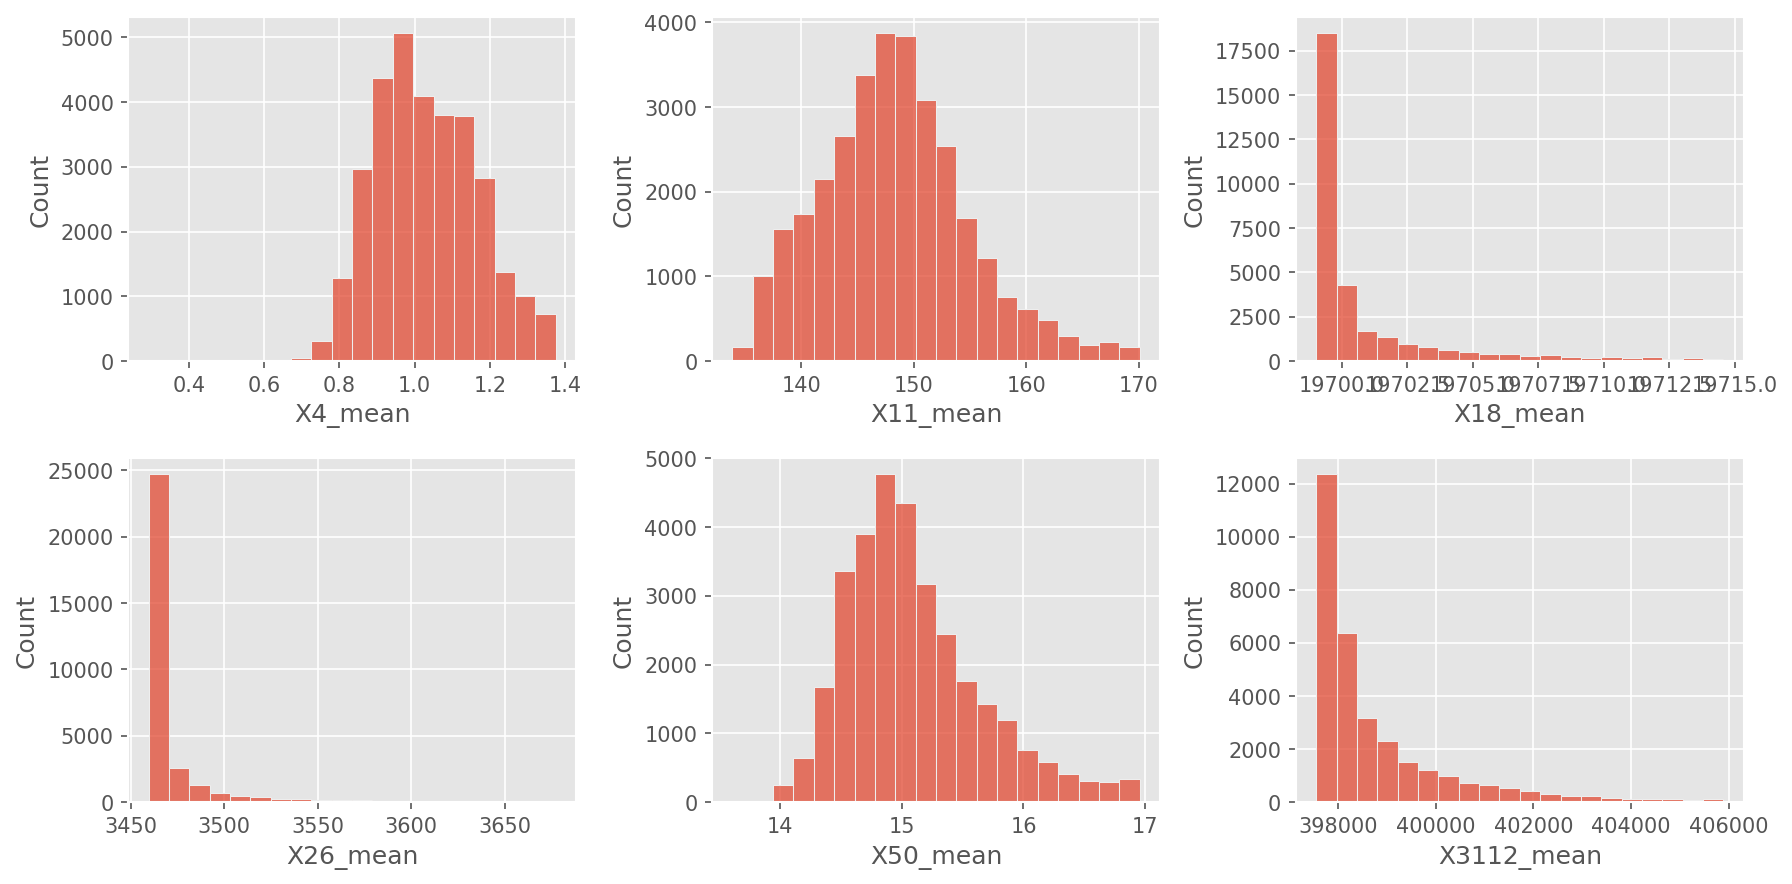

In [20]:
# histograms after filtering out bad observations
n_rows = 2
n_cols = 3
fig, axs = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows))
for i, column in enumerate(CONFIG.TRAITS_NAME):
    row_idx, col_idx = divmod(i, n_cols)
    _ = sns.histplot(data=train_df, x=column, ax=axs[row_idx, col_idx], bins=20)

fig.tight_layout()

# DATALOADER 

In [21]:
class NormalizeTarget():
    def __init__(self,type_transform ):
        self.transform = type_transform
        self.mean = 0
        self.std = 0
        self.mean_tensor = 0
        self.std_tensor = 0
        
    def normalize(self,df):
        if self.transform == "log_transform":
            mean = np.log10(df).mean()
            std = np.log10(df).std()
            min =  np.log10(df).min()
            max = np.log10(df).max()
            
            self.min  = min
            self.max = max
            
            self.mean = mean
            self.std = std
            
            self.min_tensor = torch.Tensor(self.min.values).to(DEVICE)
            self.max_tensor = torch.Tensor(self.max.values).to(DEVICE)
            
            self.mean_tensor = torch.Tensor(self.mean.values).to(DEVICE)
            self.std_tensor = torch.Tensor(self.std.values).to(DEVICE)
            
            tf = (np.log10(df) - self.min)/(self.max - self.min)
        elif self.transform == "log_transform_mean_std": 
            tf = (np.log10(df) - self.mean)/(self.std) 
        elif self.transform == None:
            tf = df
        return tf 
    def denormalize(self,df):
        if self.mean is None or self.std is None :
            raise Exception("mean and/std is not defined ")
        if self.transform  == "log_transform":
            df_denormalize =10**((df*(self.max - self.min)) + self.min )
            return df_denormalize
        if self.transform  =="log_transform_mean_std":
            df_denormalize =10**((df*self.std) + self.mean )
            return df_denormalize
        elif self.transform == None:
            df_denormalize = df
            return df_denormalize
        
    def denormalize_tensor(self,batch) :
        if self.mean_tensor is None or self.std_tensor is None :
            raise Exception("mean and/std is not defined ")
        if self.transform == "log_transform":
            df_denormalize =10**((batch*(self.max_tensor - self.min_tensor)) + self.min_tensor )
        elif self.transform == "log_transform_mean_std":
            df_denormalize =10**((batch*self.std_tensor) + self.mean_tensor )
        elif self.transform == None:
            df_denormalize = batch
        return df_denormalize
NormalizeTarget_obj = NormalizeTarget(CONFIG.NORMALIZE_TARGET)

In [22]:
class data_loader( Dataset ):
    def __init__(self,df , is_val = False):
        self.df = df.copy()
        self.is_val = is_val
        if CONFIG.NORMALIZE_TARGET == None:
            pass
        else:
            if not is_val :
                self.df[['X4_mean', 'X11_mean', 'X18_mean', 'X26_mean', 'X50_mean', 'X3112_mean' ]] = NormalizeTarget_obj.normalize(self.df[['X4_mean', 'X11_mean', 'X18_mean', 'X26_mean', 'X50_mean', 'X3112_mean' ]])
        
        
        
        self.train_transform  = A.Compose([
            #A.CLAHE(p=0.1),
            #A.RandomRotate90(p=0.1),
            #A.Transpose(p=0.4),
            #A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50, rotate_limit=45, p=.75),
            #A.Blur(blur_limit=3,p=0.1),
            #A.OpticalDistortion(p=0.1),
            #A.GridDistortion(p=0.3),
            A.HueSaturationValue(p=0.3),
            A.Resize(CONFIG.TARGET_IMAGE_SIZE, CONFIG.TARGET_IMAGE_SIZE,interpolation= cv2.INTER_LINEAR,p=1),
            A.ToFloat(),
            A.Normalize([0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225], max_pixel_value=1),
            ToTensorV2(),
            ])
        
        self.val_transform = A.Compose([
                A.Resize(CONFIG.TARGET_IMAGE_SIZE, CONFIG.TARGET_IMAGE_SIZE,interpolation= cv2.INTER_CUBIC),
                A.ToFloat(),
                    A.Normalize([0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225], max_pixel_value=1),
                    ToTensorV2(),
        ])
        self.extra_params = CONFIG.INCLUDE_EXTRA_FEATURES
        self.extra_coloumns = CONFIG.EXTRA_COLOUMN
    
    def __len__(self):
        return len(self.df)
    
    
    def __getitem__(self , index):
        row = self.df.iloc[index]
        image = plt.imread(row["image_path"])
        #image = np.copy(image)
        traits = row[CONFIG.TRAITS_NAME].values.astype(np.float32)
        traits = torch.tensor(traits,dtype=torch.float32)
        if not self.is_val:
            image = self.train_transform(image = image)["image"]
            #image = torch.permute(image  )
        else:
            image = self.val_transform(image = image)["image"]
            
        if self.extra_params:
            extras = row[self.extra_coloumns].values.astype(np.float32)
            return image , traits  , torch.tensor(extras,dtype=torch.float32)
        return  image , traits



train_dataset = data_loader(train_df, is_val = False )
val_dataset  = data_loader(val_df,   is_val = True)    

train_dataloader = DataLoader(train_dataset , batch_size = CONFIG.TRAIN_BATCH_SIZE , shuffle=True, num_workers=psutil.cpu_count() ,drop_last=True)
val_dataloader = DataLoader(val_dataset , batch_size =  CONFIG.VAL_BATCH_SIZE , shuffle=False, num_workers=psutil.cpu_count() ,drop_last=True)


# Define Model

In [23]:
def initialize_timm_model( model_name   , tim_num_class=0.0):
    model_ft  = None
    if model_name == "resnet34" :
        """ Resnet34 """
        model = timm.create_model('resnet34' , num_classes=tim_num_class )
        return model
    if model_name == "Swin_Transformer":
        model = timm.create_model('swin_tiny_patch4_window7_224.ms_in22k' , pretrained=True , num_classes = tim_num_class)
        return model 
    if model_name == "swin_large":
        model = timm.create_model('swinv2_large_window12to16_192to256.ms_in22k_ft_in1k',pretrained=True, num_classes = tim_num_class)
        #model.load_state_dict(torch.load(weight_path))
        model.head.drop = nn.Dropout(p=0.1,inplace=False)
        return model
    if model_name =="convnextv2":
        model = timm.create_model('convnext_tiny.in12k_ft_in1k_384',num_classes=tim_num_class)
        return model     
    if model_name == "efficientnet_v2":
        model = timm.create_model("efficientnet_b2.ra_in1k",pretrained = True)
        model.classifier = nn.Dropout(p=0.2,inplace=False)
        return model
    if model_name == "vit":
        model = timm.create_model('vit_base_patch16_224.augreg2_in21k_ft_in1k', pretrained=True)
        # get model specific transforms (normalization, resize)
        data_config = timm.data.resolve_model_data_config(model)
        transforms = timm.data.create_transform(**data_config, is_training=False)
        return model
tm_model = initialize_timm_model("swin_large",tim_num_class=CONFIG.TIM_NUM_CLASS)
data_config = timm.data.resolve_model_data_config(tm_model)
transforms = timm.data.create_transform(**data_config, is_training=True)


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/swinv2_large_window12to16_192to256.ms_in22k_ft_in1k)
INFO:timm.models._hub:[timm/swinv2_large_window12to16_192to256.ms_in22k_ft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Missing keys (head.fc.weight, head.fc.bias) discovered while loading pretrained weights. This is expected if model is being adapted.


In [24]:
class CustomModel(nn.Module):
    def __init__(self,input_channels,out_channels, target_features , tim_num_class , model_name):
        super().__init__()
        self.backbone = initialize_timm_model(model_name=model_name ,tim_num_class=tim_num_class)
        
        
        # tabular model 
        self.extra_parameters_models = nn.Sequential(
            nn.Linear(input_channels,input_channels*2),
            nn.BatchNorm1d(num_features=input_channels*2),
            nn.GELU(),
            nn.Linear(input_channels*2, out_channels),
            )
        self.output = nn.Sequential(
            nn.Linear(tim_num_class+out_channels,1024),
            nn.BatchNorm1d(1024),
            nn.GELU(),
            # nn.Dropout(0.1),
            nn.Linear(1024, 256),
            nn.BatchNorm1d(256),
            nn.GELU(),
            # nn.Dropout(0.1),
            nn.Linear(256, target_features),
        )
        
    def forward(self,image,x):
        output_image = self.backbone(image) # bach * (hight*col)
        z = self.extra_parameters_models(x) # batch * 16
        inputs  = torch.cat((output_image,z), 1 )
        output = self.output(inputs)
        return output
class BestModelSaveCallback:
    def __init__(self, save_path):
        self.save_path = save_path
        self.best_accuracy = -1

    def __call__(self, accuracy,model):
        if accuracy > self.best_accuracy:
            self.best_accuracy = accuracy
            model.to(device = "cpu")
            torch.save(model.state_dict(), self.save_path)
            model.to(device=DEVICE)


In [25]:

if CONFIG.INCLUDE_EXTRA_FEATURES:
    model = CustomModel(input_channels = len(CONFIG.EXTRA_COLOUMN) ,out_channels =CONFIG.TABULAR_NN_OUTPUT, target_features = len(CONFIG.TRAITS_NAME), tim_num_class=CONFIG.TIM_NUM_CLASS , model_name=CONFIG.TIM_MODEL_NAME)
else:
    model = initialize_timm_model(model_name=CONFIG.TIM_MODEL_NAME , tim_num_class = len(CONFIG.TRAITS_NAME) )    
model.to(device = DEVICE)


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/swinv2_large_window12to16_192to256.ms_in22k_ft_in1k)
INFO:timm.models._hub:[timm/swinv2_large_window12to16_192to256.ms_in22k_ft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Missing keys (head.fc.weight, head.fc.bias) discovered while loading pretrained weights. This is expected if model is being adapted.


CustomModel(
  (backbone): SwinTransformerV2(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
    )
    (layers): Sequential(
      (0): SwinTransformerV2Stage(
        (downsample): Identity()
        (blocks): ModuleList(
          (0): SwinTransformerV2Block(
            (attn): WindowAttention(
              (cpb_mlp): Sequential(
                (0): Linear(in_features=2, out_features=512, bias=True)
                (1): ReLU(inplace=True)
                (2): Linear(in_features=512, out_features=6, bias=False)
              )
              (qkv): Linear(in_features=192, out_features=576, bias=False)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=192, out_features=192, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (norm1): LayerNo

# Define Loss Metric for the Model and MISC

In [26]:
# optimizer
import torcheval.metrics
import torcheval.metrics.regression


optimizer = torch.optim.AdamW(
    params=model.parameters(),
    lr=CONFIG.LR_MAX,
    weight_decay=CONFIG.WEIGHT_DECAY,
)

# lr scheduler
def get_lr_scheduler(optimizer):
    return torch.optim.lr_scheduler.OneCycleLR(
        optimizer=optimizer,
        max_lr=CONFIG.LR_MAX,
        total_steps=CONFIG.N_STEPS,
        pct_start=0.1,
        anneal_strategy='cos',
        div_factor=1e1,
        final_div_factor=1e1,
    )
    
    
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val):
        self.sum += val.sum()
        self.count += val.numel()
        self.avg = self.sum / self.count
        
MSE = torcheval.metrics.regression.MeanSquaredError().to(DEVICE)
R2sc = torcheval.metrics.regression.R2Score(num_regressors=len(CONFIG.TRAITS_NAME) , multioutput="uniform_average").to(DEVICE)
R2sc_val = torcheval.metrics.regression.R2Score(num_regressors=len(CONFIG.TRAITS_NAME) , multioutput="uniform_average").to(DEVICE)
MSE_val = torcheval.metrics.regression.MeanSquaredError().to(DEVICE)
LOSS = AverageMeter()
TARGET_TRAITS_MEAN = torch.tensor(train_df[CONFIG.TRAITS_NAME].mean().values).to(DEVICE)        # target mean accross the training dataset
EPS = torch.tensor([1e-6]).to('cuda')


# just to check if r2 loss is also decreasing 
def r2_loss(y_pred, y_true):
    ss_res = torch.sum((y_true - y_pred)**2, dim=0)
    ss_total = torch.sum((y_true - TARGET_TRAITS_MEAN)**2, dim=0)
    ss_total = torch.maximum(ss_total, EPS)
    r2 = torch.mean(ss_res / ss_total)
    return r2

LOSS_FN = nn.SmoothL1Loss() # r2_loss
LR_SCHEDULER = get_lr_scheduler(optimizer)

In [27]:
MSE = torcheval.metrics.regression.MeanSquaredError().to(DEVICE)
y_pred = torch.ones(13,6).to(DEVICE)
y = torch.randn(13,6).to(DEVICE)
MSE.update(y_pred,y)
MSE.compute().item()

1.7677357196807861

In [28]:
y_pred = torch.ones(13,6).to(DEVICE)
y = torch.randn(13,6).to(DEVICE)
MSE.update(y_pred,y)
MSE.compute().item()

1.8661283254623413

In [29]:
def train_batch(inputs,model):
    model.train()  
    if CONFIG.INCLUDE_EXTRA_FEATURES :
        x,y,z = inputs
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        z = z.to(DEVICE)
        y_pred = model(x,z)        
        
    else:
        x,y = inputs
        x = x.to(DEVICE)
        y = y.to(DEVICE)    
        y_pred = model(x)
    
    
    #loss_func = nn.MSELoss()
    #loss_val = loss_func(prediction,y)
    loss = LOSS_FN(y_pred,y) 
    LOSS.update(loss)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    LR_SCHEDULER.step()
    MSE.update(y_pred,y)
    R2sc.update(y_pred , y )
    return r2_loss.detach().cpu().numpy() ,MSE.compute().item() ,R2sc.compute().item()

@torch.no_grad
def do_prediction(inputs,model, is_val=False):
    global Train_std_tensor , Train_mean_tensor
    model.eval()
    if  CONFIG.INCLUDE_EXTRA_FEATURES:
        x,y,z = inputs
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        z = z.to(DEVICE)
        prediction = model(x,z)
    else:
        x,y = inputs
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        prediction = model(x)
    if is_val :
        prediction = NormalizeTarget_obj.denormalize_tensor(batch=prediction)
    MSE_val.update(y_pred,y)
    R2sc_val.update(y_pred , y )
    return prediction.detach().cpu().numpy() ,MSE_val.compute().item() ,R2sc_val.compute().item()

@torch.no_grad()
def validation_loss_batch(inputs,model):
    global Train_std_tensor , Train_mean_tensor
    model.eval()
    if CONFIG.INCLUDE_EXTRA_FEATURES:
        x,y,z = inputs
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        z = z.to(DEVICE)
        prediction = model(x,z)
    else:
        x,y = inputs
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        prediction = model(x)
    prediction = NormalizeTarget_obj.denormalize_tensor(batch=prediction)
    loss = LOSS_FN(prediction, y)
    return loss.detach().cpu().numpy()

def utils_convert_to_2d_tensors(predictions,targets):
    predictions  = np.array(predictions)
    targets = np.array(targets)
    predictions  = np.reshape(predictions , (-1, predictions.shape[-1]))
    targets  = np.reshape(targets  , (-1 , targets.shape[-1]))
    return torch.Tensor(predictions), torch.Tensor(targets)

def train(trainLoader,valLoader,model,num_epochs,best_model_callback):
    #wandb.watch(model,loss_function,log = "all",log_freq=50)
    
    train_epoch_loss , train_epoch_r2 , train_epoch_mse =[] , [] , []
    val_epoch_loss , val_epoch_r2 , val_epoch_mse = [],[],[]
    
    
    for epoch in range(num_epochs):
        # print(f"epoch: {epoch} , lr is { LR_SCHEDULER.get_last_lr()}" )
        train_loss_current_epoch ,train_mse_current_epoch, train_r2_current_epoch = [] , [] , []
        
        
        # batch training loss
        with tqdm.tqdm(total=len(trainLoader)) as trainingLoop:
            for index,batch in enumerate(iter(trainLoader)): 
        
                loss,mse_ , r2_ = train_batch(batch,model)
                train_loss_current_epoch.append(loss)
                train_mse_current_epoch.append(mse_)
                train_r2_current_epoch.append(r2_)
                
                trainingLoop.set_description(f"Batch: {index}/{len(trainLoader)} ")
                trainingLoop.set_postfix(f"batch { index } :loss is : {loss} , MSE:  {mse_:.4f} , R2:  {r2_:.4f}, lr was { LR_SCHEDULER.get_last_lr()}")
                trainingLoop.update(1)
                ##wandb.log({"Training Loss":loss })
        
        train_epoch_loss.append(np.array(train_loss_current_epoch).mean() )
        train_epoch_r2.append(np.array(train_r2_current_epoch).mean())
        train_epoch_mse.append(np.array(train_mse_current_epoch).mean())
        
        # validation set loss & accuracy  
        val_loss_current_epoch ,val_mse_current_epoch, val_r2_current_epoch = [] , [] , []
        with tqdm.tqdm(total = len(valLoader)) as validationLoop:
            for index,batch in enumerate(iter(valLoader)):
                
                loss,mse_ , r2_ = validation_loss_batch(batch,model)
                val_loss_current_epoch.append(loss)
                val_mse_current_epoch.append(mse_) 
                val_r2_current_epoch.append(r2_)
                validationLoop.set_description(f"Batch: {index}/{len(valLoader)}")
                validationLoop.set_postfix({"Validation loss " : loss}) 
                ##wandb.log({"Vlaidation loss" : loss})
                #wandb.log({"Validation Loss ": val_loss.item()})
                validationLoop.update(1)



        val_epoch_loss.append(np.array(val_loss_current_epoch).mean())
        val_epoch_r2.append(np.array(r2_).mean())
        val_epoch_mse.append(np.array(mse_).mean())
        print(f"epoch:{epoch}, Training (avg) loss : {train_epoch_loss[-1]} , Validation loss (avg) = {val_epoch_loss[-1]}")
        print(f"epoch:{epoch}, Training (avg) r2 : {train_epoch_r2[-1]} , Validation r2(avg) = {val_epoch_r2[-1]}")
        
        best_model_callback(val_epoch_r2[-1],model)        # save the best model according to the validation accuracy
        
        
    return train_epoch_loss,val_epoch_loss,train_epoch_r2 , val_epoch_r2


In [30]:
MODEL_SAVE_DIR = 'saved_model'
MODEL_NAME_SAVE = 'only_image_resnet.pth'
best_model_callback = BestModelSaveCallback(save_path=os.path.join(CONFIG.BASE_DIR,MODEL_SAVE_DIR,MODEL_NAME_SAVE))
train_losses, val_losses , train_accuracies,val_accuracies = train(train_dataloader,val_dataloader,model,CONFIG.NUM_EPOCHS,best_model_callback)

  0%|          | 0/989 [00:01<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 192.00 MiB. GPU 0 has a total capacity of 23.67 GiB of which 42.06 MiB is free. Including non-PyTorch memory, this process has 23.62 GiB memory in use. Of the allocated memory 23.33 GiB is allocated by PyTorch, and 45.55 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

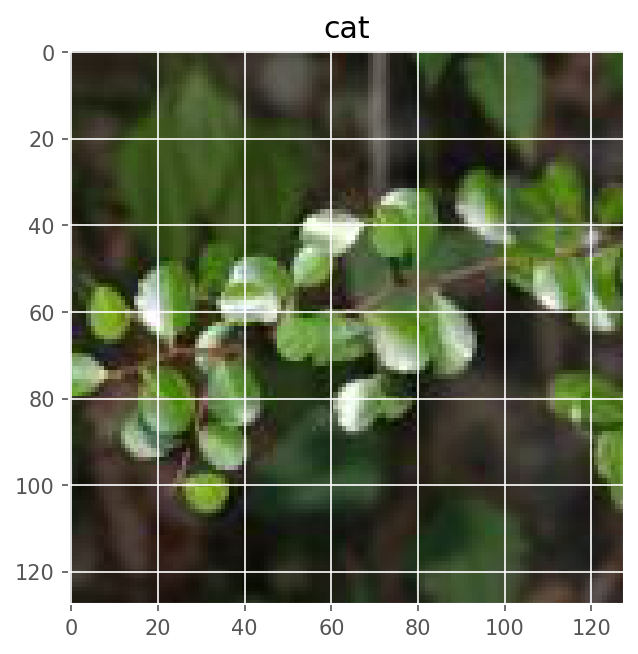

In [ ]:

# from urllib.request import urlopen
# from PIL import Image
# img = Image.open(urlopen(
#     'https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/beignets-task-guide.png'
# ))

# def Show_Image(Image, Picture_Name):
#     plt.imshow(Image)
#     plt.title(Picture_Name)
#     plt.show()
# train_transform =A.Compose([
#         A.RandomRotate90(),
#         A.Flip(),
#         A.Transpose(),
#         A.GaussNoise(),
#         A.OneOf([
#             A.MotionBlur(p=.2),
#             A.MedianBlur(blur_limit=3, p=0.1),
#             A.Blur(blur_limit=3, p=0.1),
#         ], p=0.2),
#         A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
#         A.OneOf([
#             A.OpticalDistortion(p=0.3),
#             A.GridDistortion(p=.1),
#         ], p=0.2),
#         A.OneOf([
#             A.CLAHE(clip_limit=2),
#             A.RandomBrightnessContrast(),
#         ], p=0.3),
#         A.HueSaturationValue(p=0.3),
#         A.Resize(CONFIG.TARGET_IMAGE_SIZE, CONFIG.TARGET_IMAGE_SIZE,interpolation= cv2.INTER_LINEAR,p=0.5),
#         A.ToFloat(),
#         A.Normalize([0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225], max_pixel_value=1),
#         ToTensorV2(),
#     ])
# img = plt.imread(train_df.iloc[200]["image_path"])
# img2 = train_transform(image = img)["image"]
# Show_Image( img, 'cat')
# Show_Image( img2, 'cat')